# Fase 4 – Modelado supervisado y comparación de algoritmos

En esta fase se construye y evalúa un conjunto de modelos de clasificación supervisada para el problema binario de exoplanetas del catálogo KOI: distinguir entre objetos etiquetados como `CONFIRMED` y `FALSE_POSITIVE`.

Partimos del conjunto de datos ya preprocesado y enriquecido en las fases anteriores, y nos centramos en:

- Definir conjuntos de características (todas vs. solo físicas).
- Entrenar varios modelos clásicos de aprendizaje supervisado.
- Realizar búsqueda de hiperparámetros mediante validación cruzada.
- Comparar el desempeño de los modelos en términos de *Accuracy*, *Precision*, *Recall*, *F1* y *AUC*.
- Seleccionar el mejor modelo para ser analizado en mayor detalle y reutilizado en la Fase 5.


## 4.1 Configuración del entorno de trabajo

En esta sección se importan las librerías necesarias para el modelado supervisado:

- **Pandas / NumPy** para manejo tabular y numérico.
- **Matplotlib / Seaborn** para gráficas de apoyo.
- **Scikit-learn** para los modelos de clasificación, pipelines, escalado y validación cruzada.

También se fija una semilla aleatoria para garantizar reproducibilidad y se definen algunos parámetros globales de estilo de gráficos.


In [ ]:
import numpy as np
import pandas as pd

# Modelado y validación
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Modelos
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Métricas
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 4.2 Carga del conjunto de datos enriquecido y variable objetivo

Aquí se carga el conjunto de datos enriquecido generado en la Fase 3, que ya incorpora:

- Filtrado de disposiciones a `CONFIRMED` y `FALSE_POSITIVE`.
- Limpieza básica de columnas irrelevantes o con demasiados valores faltantes.
- Variables físicas clave del sistema estrella–planeta y algunas características derivadas.

Se define:

- La **variable objetivo** (`is_confirmed`), que vale 1 para exoplanetas confirmados y 0 para falsos positivos.
- El conjunto de **características de entrada** sobre el que entrenarán los modelos.
- Una comprobación rápida del balance de clases mediante `value_counts()` para entender la proporción de exoplanetas confirmados frente a falsos positivos.


In [ ]:
# Cargar el dataset más actualizado (salida de la Fase 3)
df = pd.read_csv("/content/exoplanet_koi_binary_enriched.csv")

print("Dimensiones del dataset:", df.shape)
df.head()

Dimensiones del dataset: (7585, 51)


,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,...,koi_dikco_mdec,koi_dikco_msky,is_confirmed,log_koi_period,log_koi_prad,log_koi_teq,log_koi_insol,log_koi_depth,stellar_density,planet_to_star_radius_ratio
0,1.000,0,0,0,0,9.488036,170.538750,0.146,2.95750,615.8,...,0.310,0.320,1,2.350235,1.181727,6.677083,4.549552,6.424545,1.153656,0.022326
1,0.969,0,0,0,0,54.418383,162.513840,0.586,4.50700,874.8,...,0.120,0.500,1,4.014911,1.342865,6.095825,2.313525,6.775138,1.153656,0.027957
2,0.000,0,1,0,0,1.736952,170.307565,1.276,2.40641,8079.2,...,0.099,0.276,0,1.006845,3.539799,7.241366,6.794542,8.997172,1.689183,0.387371
3,1.000,0,0,0,0,2.525592,171.595550,0.701,1.65450,603.3,...,0.020,0.070,1,1.260048,1.321756,7.249215,6.832126,6.404071,0.956795,0.024076
4,1.000,0,0,0,0,11.094321,171.201160,0.538,4.59450,1517.5,...,-0.080,0.080,1,2.492736,1.589235,6.728629,4.751951,7.325478,1.146647,0.036743


In [ ]:
# Variable objetivo
target_col = "is_confirmed"

print("Conteo de clases (0 = FALSE POSITIVE, 1 = CONFIRMED):")
print(df[target_col].value_counts())

print("\nProporciones de clases:")
print(df[target_col].value_counts(normalize=True))

Conteo de clases (0 = FALSE POSITIVE, 1 = CONFIRMED):
is_confirmed
0    4839
1    2746
Name: count, dtype: int64

Proporciones de clases:
is_confirmed
0    0.63797
1    0.36203
Name: proportion, dtype: float64


## 4.3 Definición de conjuntos de características

Con el objetivo de analizar el compromiso entre desempeño e interpretabilidad, se definen dos configuraciones de características:

- **Conjunto “físicas”**: incluye únicamente variables astrofísicas interpretables (periodo orbital, radio del planeta, profundidad del tránsito, insolación, parámetros estelares, etc.), excluyendo columnas como `koi_score` y algunas banderas de falsos positivos que actúan casi como un “oráculo”.
- **(Opcional) Conjunto “todas”**: incluye además variables que condensan información de los pipelines de la NASA (`koi_score`, flags de falsos positivos), lo que suele mejorar las métricas pero reduce la independencia física del modelo.

A partir de estas listas se crea la matriz de características `X` correspondiente a cada configuración, manteniendo siempre la misma variable objetivo `y`.


In [ ]:
# Todas las columnas menos la etiqueta
all_feature_cols = [c for c in df.columns if c != target_col]

# Columnas "peligrosas" (demasiado informativas / casi la respuesta)
cheat_cols = ["koi_score", "koi_fpflag_nt", "koi_fpflag_ss", "koi_fpflag_co", "koi_fpflag_ec"]

# Features físicas / más "honestas"
feature_cols_phys = [c for c in all_feature_cols if c not in cheat_cols]

print("Número total de features:", len(all_feature_cols))
print("Número de features físicas (sin koi_score ni fpflags):", len(feature_cols_phys))

print("\nColumnas 'trampa' excluidas del conjunto físico:")
print(cheat_cols)

Número total de features: 50
Número de features físicas (sin koi_score ni fpflags): 45

Columnas 'trampa' excluidas del conjunto físico:
['koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec']


## 4.4 Partición estratificada en *train*, *validation* y *test*

Para evaluar de forma rigurosa los modelos, el dataset se divide en tres subconjuntos:

- **Train (~70%)**: usado para ajustar los parámetros de los modelos.
- **Validation (~15%)**: usado para la búsqueda de hiperparámetros y selección de configuraciones.
- **Test (~15%)**: reservado como conjunto independiente para la evaluación final.

Las particiones se realizan de forma **estratificada** respecto a la variable `is_confirmed`, de modo que se preserve el balance de clases en cada subconjunto. Se utiliza una semilla fija (`random_state`) para garantizar que los experimentos puedan replicarse.


In [ ]:
# === Partición explícita: TRAIN / VAL / TEST ===

X_all  = df[all_feature_cols].copy()
X_phys = df[feature_cols_phys].copy()
y      = df[target_col].copy()

# 1) Primero: Train+Val (85%) y Test (15%)
X_trainval_phys, X_test_phys, y_trainval, y_test = train_test_split(
    X_phys,
    y,
    test_size=0.15,          # 15% test
    stratify=y,
    random_state=RANDOM_STATE
)

# Alinear las features "all" con los mismos índices
X_trainval_all = X_all.loc[X_trainval_phys.index]
X_test_all     = X_all.loc[X_test_phys.index]

# 2) Dentro de Train+Val -> Train (70%) y Val (15%)
#    Eso equivale a que el conjunto de validación
#    sea 15/85 ≈ 0.176 de Train+Val
val_size_rel = 0.15 / 0.85  # ≈ 0.1765

X_train_phys, X_val_phys, y_train, y_val = train_test_split(
    X_trainval_phys,
    y_trainval,
    test_size=val_size_rel,
    stratify=y_trainval,
    random_state=RANDOM_STATE
)

# Alinear las features "all" con train y val
X_train_all = X_trainval_all.loc[X_train_phys.index]
X_val_all   = X_trainval_all.loc[X_val_phys.index]

print("Tamaños de los conjuntos:")
print("  TRAIN:", X_train_phys.shape)
print("  VAL:  ", X_val_phys.shape)
print("  TEST: ", X_test_phys.shape)

print("\nDistribución de clases (is_confirmed):")
print("  TRAIN:")
print(y_train.value_counts(normalize=True))
print("\n  VAL:")
print(y_val.value_counts(normalize=True))
print("\n  TEST:")
print(y_test.value_counts(normalize=True))

Tamaños de los conjuntos:
  TRAIN: (5309, 45)
  VAL:   (1138, 45)
  TEST:  (1138, 45)

Distribución de clases (is_confirmed):
  TRAIN:
is_confirmed
0    0.637973
1    0.362027
Name: proportion, dtype: float64

  VAL:
is_confirmed
0    0.637961
1    0.362039
Name: proportion, dtype: float64

  TEST:
is_confirmed
0    0.637961
1    0.362039
Name: proportion, dtype: float64


## 4.5 Funciones auxiliares y construcción de *pipelines*

En esta sección se definen las utilidades que estructuran el proceso de modelado:

- Una función de evaluación que calcula métricas como *Accuracy*, *Precision*, *Recall*, *F1* y *AUC*, y que puede usarse sobre distintos modelos y subconjuntos de datos.
- **Pipelines de Scikit-learn** que integran, cuando es necesario:
  - Un paso de **escalado estándar** (`StandardScaler`) para modelos sensibles a la escala (Regresión logística, SVM, KNN, MLP).
  - El **clasificador principal** (Regresión logística, KNN, SVM, Árbol de decisión, Random Forest o MLP).

Este diseño permite reutilizar una misma interfaz de entrenamiento/evaluación para múltiples modelos y facilita la búsqueda de hiperparámetros.


In [ ]:
def evaluate_model(model,
                   X_train, y_train,
                   X_val,   y_val,
                   X_test,  y_test,
                   model_name="Modelo"):
    """
    Evalúa un modelo en TRAIN, VAL y TEST.
    Devuelve un diccionario con:
      - train_accuracy, train_precision, train_recall, train_f1, train_roc_auc
      - val_accuracy,   val_precision,   val_recall,   val_f1,   val_roc_auc
      - test_accuracy,  test_precision,  test_recall,  test_f1,  test_roc_auc
    """
    metrics = {}

    # ¿El modelo devuelve probabilidades o "scores"?
    has_proba = hasattr(model, "predict_proba")
    has_dec   = hasattr(model, "decision_function")

    def eval_split(X, y, split_name):
        y_pred = model.predict(X)

        if has_proba:
            y_scores = model.predict_proba(X)[:, 1]
        elif has_dec:
            y_scores = model.decision_function(X)
        else:
            y_scores = None

        # Métricas básicas
        acc  = accuracy_score(y, y_pred)
        prec = precision_score(y, y_pred, zero_division=0)
        rec  = recall_score(y, y_pred, zero_division=0)
        f1   = f1_score(y, y_pred, zero_division=0)

        metrics[f"{split_name}_accuracy"]  = acc
        metrics[f"{split_name}_precision"] = prec
        metrics[f"{split_name}_recall"]    = rec
        metrics[f"{split_name}_f1"]        = f1

        # AUC si es posible
        if y_scores is not None:
            auc = roc_auc_score(y, y_scores)
        else:
            auc = np.nan
        metrics[f"{split_name}_roc_auc"] = auc

    # Evaluar en cada split
    eval_split(X_train, y_train, "train")
    eval_split(X_val,   y_val,   "val")
    eval_split(X_test,  y_test,  "test")

    # Resumen bonito en consola
    print(f"\n===== {model_name} =====")
    for split in ["train", "val", "test"]:
        print(f"{split.upper()}: "
              f"acc={metrics[f'{split}_accuracy']:.3f}, "
              f"prec={metrics[f'{split}_precision']:.3f}, "
              f"rec={metrics[f'{split}_recall']:.3f}, "
              f"f1={metrics[f'{split}_f1']:.3f}, "
              f"auc={metrics[f'{split}_roc_auc']:.3f}")

    # Matriz de confusión y reporte solo en TEST (para no saturar)
    y_test_pred = model.predict(X_test)
    print("\nMatriz de confusión (TEST):")
    print(confusion_matrix(y_test, y_test_pred))

    print("\nReporte de clasificación (TEST):")
    print(classification_report(y_test, y_test_pred, digits=3))

    return metrics

## 4.6 Modelos supervisados y búsqueda de hiperparámetros

Aquí se declaran los modelos supervisados clásicos que se van a comparar, junto con los rangos de hiperparámetros a explorar mediante validación cruzada:

- **Regresión logística (físicas)**: variación del parámetro de regularización `C` y uso opcional de `class_weight='balanced'`.
- **KNN**: diferentes números de vecinos (`k`) y métricas de distancia (euclídea / manhattan).
- **SVM con kernel RBF (físicas)**: variación de `C` y del parámetro del kernel (`gamma`).
- **Árbol de decisión**: límites de profundidad y número mínimo de muestras por hoja.
- **Random Forest (físicas)**: número de árboles y profundidad máxima, explorando también `max_features`.
- **MLP (físicas)**: arquitectura de capas ocultas simple (p.ej. (64,) y (64, 32)), épocas de entrenamiento y tamaños de lote razonables.

Para cada modelo se usa validación cruzada sobre el conjunto de entrenamiento/validación, con un *scoring* centrado en **F1** y **AUC**, con el fin de lidiar mejor con el ligero desbalance de clases.


In [ ]:
# Modelo trivial: siempre predice la clase mayoritaria
dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_clf.fit(X_train_phys, y_train)

metrics_dummy = evaluate_model(
    dummy_clf,
    X_train_phys, y_train,
    X_val_phys,   y_val,
    X_test_phys,  y_test,
    model_name="DummyClassifier (clase mayoritaria)"
)


===== DummyClassifier (clase mayoritaria) =====
TRAIN: acc=0.638, prec=0.000, rec=0.000, f1=0.000, auc=0.500
VAL: acc=0.638, prec=0.000, rec=0.000, f1=0.000, auc=0.500
TEST: acc=0.638, prec=0.000, rec=0.000, f1=0.000, auc=0.500

Matriz de confusión (TEST):
[[726   0]
 [412   0]]

Reporte de clasificación (TEST):
              precision    recall  f1-score   support

           0      0.638     1.000     0.779       726
           1      0.000     0.000     0.000       412

    accuracy                          0.638      1138
   macro avg      0.319     0.500     0.389      1138
weighted avg      0.407     0.638     0.497      1138



In [ ]:
# Validación cruzada estratificada (para GridSearchCV)
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE
)

In [ ]:
from sklearn.impute import SimpleImputer

# Pipeline: Imputación -> Estandarización -> Regresión logística
pipe_log = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
    ("logreg",  LogisticRegression(
        max_iter=500,
        class_weight="balanced",  # manejar desbalance
        solver="lbfgs"
    ))
])

# Grid de hiperparámetros
param_grid_log = {
    "logreg__C": [0.01, 0.1, 1, 10]
}

grid_log = GridSearchCV(
    pipe_log,
    param_grid_log,
    cv=cv,
    scoring="f1",   # F1 para balancear precision/recall
    n_jobs=-1
)

grid_log.fit(X_train_phys, y_train)

best_log_phys = grid_log.best_estimator_

print("Mejores hiperparámetros (Regresión logística, features físicas):")
print(grid_log.best_params_)

metrics_log_phys = evaluate_model(
    best_log_phys,
    X_train_phys, y_train,
    X_val_phys,   y_val,
    X_test_phys,  y_test,
    model_name="Regresión Logística (features físicas)"
)

Mejores hiperparámetros (Regresión logística, features físicas):
{'logreg__C': 10}

===== Regresión Logística (features físicas) =====
TRAIN: acc=0.938, prec=0.882, rec=0.958, f1=0.918, auc=0.981
VAL: acc=0.932, prec=0.870, rec=0.956, f1=0.911, auc=0.979
TEST: acc=0.936, prec=0.883, rec=0.949, f1=0.915, auc=0.980

Matriz de confusión (TEST):
[[674  52]
 [ 21 391]]

Reporte de clasificación (TEST):
              precision    recall  f1-score   support

           0      0.970     0.928     0.949       726
           1      0.883     0.949     0.915       412

    accuracy                          0.936      1138
   macro avg      0.926     0.939     0.932      1138
weighted avg      0.938     0.936     0.936      1138



In [ ]:
# Extraer coeficientes del modelo (ya escalado)
log_reg = best_log_phys.named_steps["logreg"]
coefs   = log_reg.coef_[0]

coef_df = pd.DataFrame({
    "feature": feature_cols_phys,
    "coef":    coefs
}).sort_values(by="coef", ascending=False)

print("Top 15 features con coeficiente POSITIVO (aumentan prob. de confirmado):")
display(coef_df.head(15))

print("\nTop 15 features con coeficiente NEGATIVO (disminuyen prob. de confirmado):")
display(coef_df.tail(15))

Top 15 features con coeficiente POSITIVO (aumentan prob. de confirmado):


,feature,coef
42,log_koi_depth,2.345997
14,koi_model_snr,1.474774
8,koi_teq,1.238134
15,koi_count,1.152708
21,koi_smet,0.761180
30,koi_fwm_prao,0.629703
32,koi_dicco_mra,0.517933
19,koi_steff,0.508364
27,koi_fwm_stat_sig,0.450319
18,koi_bin_oedp_sig,0.289718



Top 15 features con coeficiente NEGATIVO (disminuyen prob. de confirmado):


,feature,coef
36,koi_dikco_mdec,-0.952564
34,koi_dicco_msky,-1.567437
3,koi_duration,-1.649905
31,koi_fwm_pdeco,-1.791414
20,koi_slogg,-1.915730
38,log_koi_period,-2.300929
10,koi_dor,-2.412149
5,koi_srho,-2.491874
37,koi_dikco_msky,-2.843010
39,log_koi_prad,-2.981467


In [ ]:
# Pipeline: Imputación -> Estandarización -> KNN
pipe_knn = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
    ("knn",     KNeighborsClassifier())
])

param_grid_knn = {
    "knn__n_neighbors": [3, 5, 7, 9, 11],
    "knn__weights":     ["uniform", "distance"],
    "knn__p":           [1, 2]   # 1 = Manhattan, 2 = Euclídea
}

grid_knn = GridSearchCV(
    pipe_knn,
    param_grid_knn,
    cv=cv,
    scoring="f1",
    n_jobs=-1
)

grid_knn.fit(X_train_phys, y_train)

best_knn = grid_knn.best_estimator_

print("Mejores hiperparámetros (KNN, features físicas):")
print(grid_knn.best_params_)

metrics_knn = evaluate_model(
    best_knn,
    X_train_phys, y_train,
    X_val_phys,   y_val,
    X_test_phys,  y_test,
    model_name="KNN (features físicas)"
)

Mejores hiperparámetros (KNN, features físicas):
{'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'uniform'}

===== KNN (features físicas) =====
TRAIN: acc=0.949, prec=0.896, rec=0.972, f1=0.933, auc=0.993
VAL: acc=0.931, prec=0.860, rec=0.966, f1=0.910, auc=0.974
TEST: acc=0.932, prec=0.870, rec=0.956, f1=0.911, auc=0.976

Matriz de confusión (TEST):
[[667  59]
 [ 18 394]]

Reporte de clasificación (TEST):
              precision    recall  f1-score   support

           0      0.974     0.919     0.945       726
           1      0.870     0.956     0.911       412

    accuracy                          0.932      1138
   macro avg      0.922     0.938     0.928      1138
weighted avg      0.936     0.932     0.933      1138



In [ ]:
# Pipeline: Imputación -> Estandarización -> SVC
pipe_svm = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
    ("svc",     SVC(
        class_weight="balanced",
        probability=True  # para ROC-AUC
    ))
])

param_grid_svm = [
    # SVM lineal
    {
        "svc__kernel": ["linear"],
        "svc__C":      [0.1, 1, 10]
    },
    # SVM RBF
    {
        "svc__kernel": ["rbf"],
        "svc__C":      [0.1, 1, 10],
        "svc__gamma":  ["scale", "auto"]
    }
]

grid_svm = GridSearchCV(
    pipe_svm,
    param_grid_svm,
    cv=cv,
    scoring="f1",
    n_jobs=-1
)

grid_svm.fit(X_train_phys, y_train)

best_svm = grid_svm.best_estimator_

print("Mejores hiperparámetros (SVM, features físicas):")
print(grid_svm.best_params_)

metrics_svm = evaluate_model(
    best_svm,
    X_train_phys, y_train,
    X_val_phys,   y_val,
    X_test_phys,  y_test,
    model_name="SVM RBF (features físicas)"
)

Mejores hiperparámetros (SVM, features físicas):
{'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}

===== SVM RBF (features físicas) =====
TRAIN: acc=0.965, prec=0.920, rec=0.989, f1=0.953, auc=0.994
VAL: acc=0.957, prec=0.915, rec=0.971, f1=0.942, auc=0.993
TEST: acc=0.951, prec=0.903, rec=0.968, f1=0.934, auc=0.986

Matriz de confusión (TEST):
[[683  43]
 [ 13 399]]

Reporte de clasificación (TEST):
              precision    recall  f1-score   support

           0      0.981     0.941     0.961       726
           1      0.903     0.968     0.934       412

    accuracy                          0.951      1138
   macro avg      0.942     0.955     0.948      1138
weighted avg      0.953     0.951     0.951      1138



In [ ]:
# Pipeline: Imputación -> Árbol de decisión
pipe_tree = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("tree",    DecisionTreeClassifier(
        random_state=RANDOM_STATE,
        class_weight="balanced"
    ))
])

param_grid_tree = {
    "tree__max_depth":       [3, 5, 7, 10, None],
    "tree__min_samples_leaf":[1, 5, 10]
}

grid_tree = GridSearchCV(
    pipe_tree,
    param_grid_tree,
    cv=cv,
    scoring="f1",
    n_jobs=-1
)

grid_tree.fit(X_train_phys, y_train)

best_tree = grid_tree.best_estimator_

print("Mejores hiperparámetros (Árbol, features físicas):")
print(grid_tree.best_params_)

metrics_tree = evaluate_model(
    best_tree,
    X_train_phys, y_train,
    X_val_phys,   y_val,
    X_test_phys,  y_test,
    model_name="Árbol de decisión (features físicas)"
)

Mejores hiperparámetros (Árbol, features físicas):
{'tree__max_depth': None, 'tree__min_samples_leaf': 10}

===== Árbol de decisión (features físicas) =====
TRAIN: acc=0.964, prec=0.931, rec=0.972, f1=0.951, auc=0.996
VAL: acc=0.939, prec=0.889, rec=0.951, f1=0.919, auc=0.979
TEST: acc=0.947, prec=0.902, rec=0.959, f1=0.929, auc=0.974

Matriz de confusión (TEST):
[[683  43]
 [ 17 395]]

Reporte de clasificación (TEST):
              precision    recall  f1-score   support

           0      0.976     0.941     0.958       726
           1      0.902     0.959     0.929       412

    accuracy                          0.947      1138
   macro avg      0.939     0.950     0.944      1138
weighted avg      0.949     0.947     0.948      1138



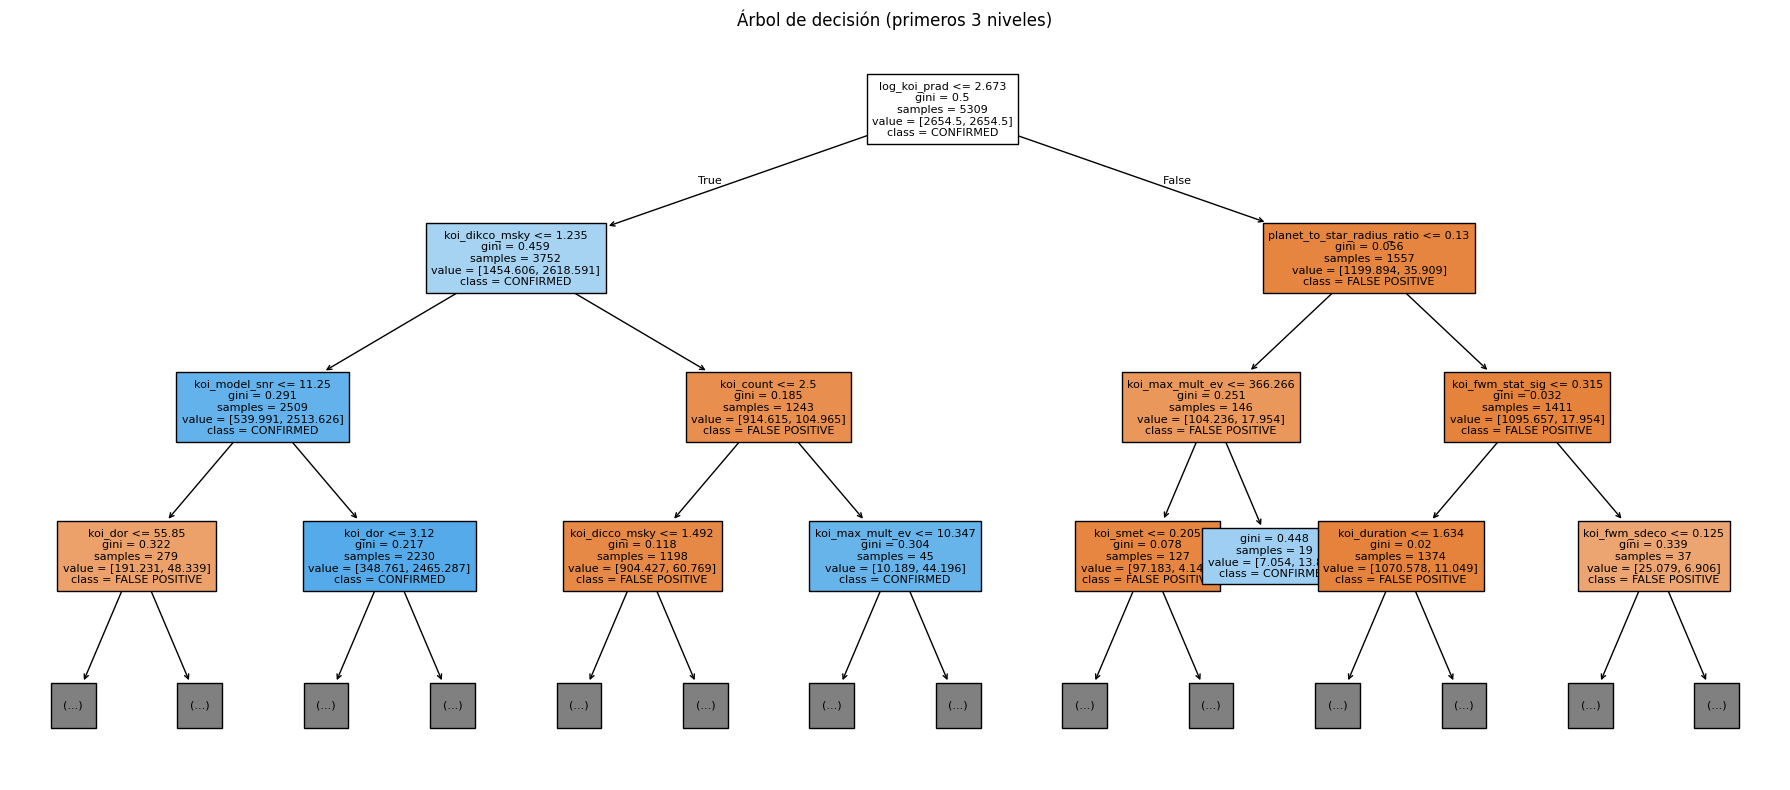

In [ ]:
# Extraemos el árbol interno (dentro del pipeline)
tree_model = best_tree.named_steps["tree"]

plt.figure(figsize=(18, 8))
plot_tree(
    tree_model,
    feature_names=feature_cols_phys,
    class_names=["FALSE POSITIVE", "CONFIRMED"],
    max_depth=3,       # solo primeros niveles para que se vea
    filled=True,
    fontsize=8
)
plt.title("Árbol de decisión (primeros 3 niveles)")
plt.tight_layout()
plt.show()

In [ ]:
# Pipeline: Imputación -> Random Forest
pipe_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("rf",      RandomForestClassifier(
        random_state=RANDOM_STATE,
        class_weight="balanced",
        n_estimators=200,
        n_jobs=-1
    ))
])

param_grid_rf = {
    "rf__max_depth":   [5, 10, None],
    "rf__max_features":["sqrt", "log2", 0.5]
}

grid_rf = GridSearchCV(
    pipe_rf,
    param_grid_rf,
    cv=cv,
    scoring="f1",
    n_jobs=-1
)

grid_rf.fit(X_train_phys, y_train)

best_rf_phys = grid_rf.best_estimator_

print("Mejores hiperparámetros (Random Forest, features físicas):")
print(grid_rf.best_params_)

metrics_rf_phys = evaluate_model(
    best_rf_phys,
    X_train_phys, y_train,
    X_val_phys,   y_val,
    X_test_phys,  y_test,
    model_name="Random Forest (features físicas)"
)

Mejores hiperparámetros (Random Forest, features físicas):
{'rf__max_depth': None, 'rf__max_features': 'sqrt'}

===== Random Forest (features físicas) =====
TRAIN: acc=1.000, prec=1.000, rec=1.000, f1=1.000, auc=1.000
VAL: acc=0.975, prec=0.971, rec=0.959, f1=0.965, auc=0.996
TEST: acc=0.971, prec=0.961, rec=0.959, f1=0.960, auc=0.995

Matriz de confusión (TEST):
[[710  16]
 [ 17 395]]

Reporte de clasificación (TEST):
              precision    recall  f1-score   support

           0      0.977     0.978     0.977       726
           1      0.961     0.959     0.960       412

    accuracy                          0.971      1138
   macro avg      0.969     0.968     0.969      1138
weighted avg      0.971     0.971     0.971      1138



Top 15 features más importantes según Random Forest:


,0
koi_dikco_msky,0.104010
koi_dicco_msky,0.101261
log_koi_prad,0.071732
koi_prad,0.063514
planet_to_star_radius_ratio,0.055584
koi_model_snr,0.050346
koi_count,0.049354
koi_fwm_stat_sig,0.044857
koi_max_mult_ev,0.039889
koi_dor,0.035095


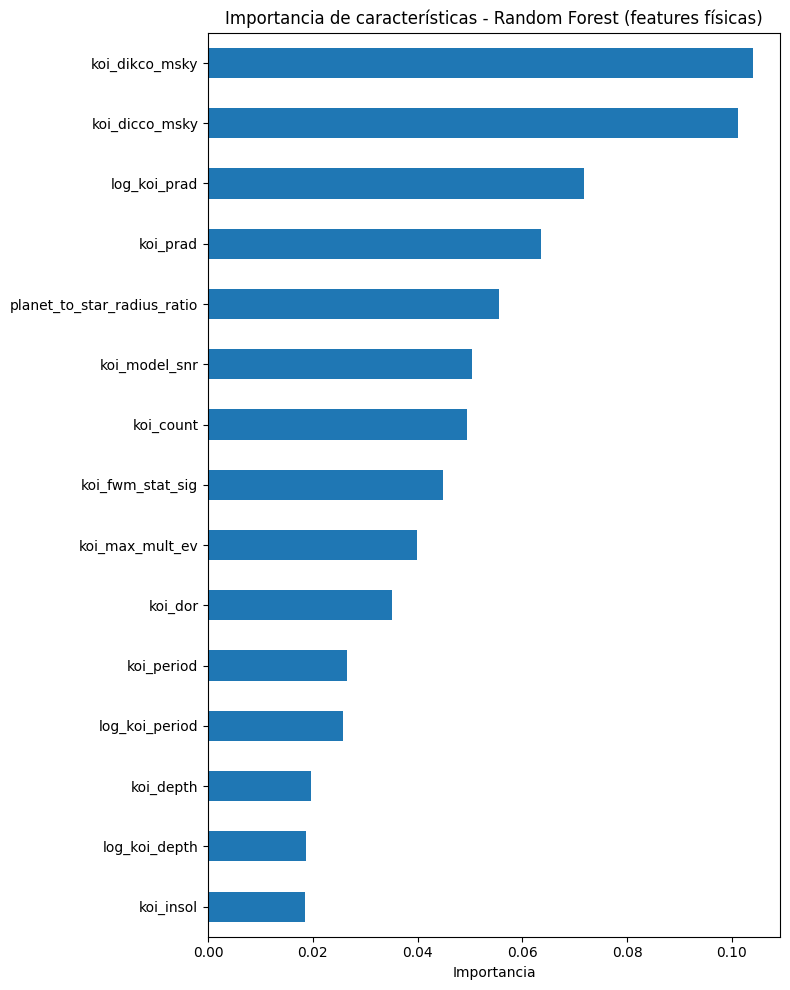

In [ ]:
# Extraemos el modelo RF del pipeline
rf_model = best_rf_phys.named_steps["rf"]

importances = pd.Series(
    rf_model.feature_importances_,
    index=feature_cols_phys
).sort_values(ascending=False)

print("Top 15 features más importantes según Random Forest:")
display(importances.head(15))

plt.figure(figsize=(8, 10))
importances.head(15).sort_values().plot(kind="barh")
plt.xlabel("Importancia")
plt.title("Importancia de características - Random Forest (features físicas)")
plt.tight_layout()
plt.show()

In [ ]:
# Pipeline: Imputación -> Estandarización -> MLP (red neuronal feedforward)
pipe_mlp = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
    ("mlp",     MLPClassifier(
        max_iter=300,
        random_state=RANDOM_STATE
    ))
])

param_grid_mlp = {
    "mlp__hidden_layer_sizes": [(32,), (64, 32)],
    "mlp__alpha":              [0.0001, 0.001],
    "mlp__learning_rate_init": [0.001, 0.0005]
}

grid_mlp = GridSearchCV(
    pipe_mlp,
    param_grid_mlp,
    cv=cv,
    scoring="f1",
    n_jobs=-1
)

grid_mlp.fit(X_train_phys, y_train)

best_mlp = grid_mlp.best_estimator_

print("Mejores hiperparámetros (MLP, features físicas):")
print(grid_mlp.best_params_)

metrics_mlp = evaluate_model(
    best_mlp,
    X_train_phys, y_train,
    X_val_phys,   y_val,
    X_test_phys,  y_test,
    model_name="MLP (features físicas, red neuronal simple)"
)

Mejores hiperparámetros (MLP, features físicas):
{'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (32,), 'mlp__learning_rate_init': 0.001}

===== MLP (features físicas, red neuronal simple) =====
TRAIN: acc=0.988, prec=0.974, rec=0.992, f1=0.983, auc=0.999
VAL: acc=0.968, prec=0.956, rec=0.956, f1=0.956, auc=0.990
TEST: acc=0.953, prec=0.924, rec=0.947, f1=0.935, auc=0.987

Matriz de confusión (TEST):
[[694  32]
 [ 22 390]]

Reporte de clasificación (TEST):
              precision    recall  f1-score   support

           0      0.969     0.956     0.963       726
           1      0.924     0.947     0.935       412

    accuracy                          0.953      1138
   macro avg      0.947     0.951     0.949      1138
weighted avg      0.953     0.953     0.953      1138



In [ ]:
grid_log_all = GridSearchCV(
    pipe_log,           # el mismo pipeline: imputación + scaler + logreg
    param_grid_log,
    cv=cv,
    scoring="f1",
    n_jobs=-1
)

grid_log_all.fit(X_train_all, y_train)

best_log_all = grid_log_all.best_estimator_

print("Mejores hiperparámetros (LogReg, TODAS las features incl. koi_score):")
print(grid_log_all.best_params_)

metrics_log_all = evaluate_model(
    best_log_all,
    X_train_all, y_train,
    X_val_all,   y_val,
    X_test_all,  y_test,
    model_name="Regresión Logística (todas las features, incl. koi_score)"
)

Mejores hiperparámetros (LogReg, TODAS las features incl. koi_score):
{'logreg__C': 1}

===== Regresión Logística (todas las features, incl. koi_score) =====
TRAIN: acc=0.996, prec=0.992, rec=0.997, f1=0.995, auc=1.000
VAL: acc=0.996, prec=1.000, rec=0.988, f1=0.994, auc=1.000
TEST: acc=0.992, prec=0.993, rec=0.985, f1=0.989, auc=0.997

Matriz de confusión (TEST):
[[723   3]
 [  6 406]]

Reporte de clasificación (TEST):
              precision    recall  f1-score   support

           0      0.992     0.996     0.994       726
           1      0.993     0.985     0.989       412

    accuracy                          0.992      1138
   macro avg      0.992     0.991     0.991      1138
weighted avg      0.992     0.992     0.992      1138



## 4.7 Evaluación detallada del mejor modelo en *test*

A partir de la tabla comparativa, se selecciona como mejor modelo al:

- **Random Forest (físicas)**, que alcanza aproximadamente:
  - F1 en *test* ≈ 0.95
  - AUC en *test* ≈ 0.99

En esta sección se:

- Vuelven a entrenar los modelos seleccionados con los datos de *train*.
- Se evalúan en *validation* para comprobar la consistencia de las métricas.
- Finalmente, se calculan las métricas en el conjunto de **test**, incluyendo:
  - Matriz de confusión.
  - Informe de clasificación (*classification report*).
  - Curvas ROC, en particular para el Random Forest seleccionado.


In [ ]:
grid_rf_all = GridSearchCV(
    pipe_rf,          # mismo pipeline: imputación + RF
    param_grid_rf,
    cv=cv,
    scoring="f1",
    n_jobs=-1
)

grid_rf_all.fit(X_train_all, y_train)

best_rf_all = grid_rf_all.best_estimator_

print("Mejores hiperparámetros (RF, TODAS las features incl. koi_score):")
print(grid_rf_all.best_params_)

metrics_rf_all = evaluate_model(
    best_rf_all,
    X_train_all, y_train,
    X_val_all,   y_val,
    X_test_all,  y_test,
    model_name="Random Forest (todas las features, incl. koi_score)"
)

Mejores hiperparámetros (RF, TODAS las features incl. koi_score):
{'rf__max_depth': 10, 'rf__max_features': 0.5}

===== Random Forest (todas las features, incl. koi_score) =====
TRAIN: acc=1.000, prec=1.000, rec=0.999, f1=1.000, auc=1.000
VAL: acc=0.994, prec=1.000, rec=0.983, f1=0.991, auc=1.000
TEST: acc=0.993, prec=1.000, rec=0.981, f1=0.990, auc=1.000

Matriz de confusión (TEST):
[[726   0]
 [  8 404]]

Reporte de clasificación (TEST):
              precision    recall  f1-score   support

           0      0.989     1.000     0.995       726
           1      1.000     0.981     0.990       412

    accuracy                          0.993      1138
   macro avg      0.995     0.990     0.992      1138
weighted avg      0.993     0.993     0.993      1138



## 4.8 Entrenamiento, validación y tabla comparativa de resultados

En este bloque se ejecuta el *loop* principal de experimentación:

1. Para cada modelo y su grilla de hiperparámetros:
   - Se entrena mediante validación cruzada en el conjunto de *train*.
   - Se evalúa el mejor estimador en *validation*.
2. Se registran las métricas más relevantes:
   - *Accuracy*, *F1* y *AUC* en entrenamiento y validación.
3. Se construye una **tabla comparativa** (`resultados_modelos`) que resume el desempeño de todos los modelos.

Esta tabla sirve como base para seleccionar el modelo que ofrece el mejor equilibrio entre rendimiento y capacidad de generalización.


In [ ]:
# Construimos una tabla resumen con F1 y accuracy en test

results = pd.DataFrame([
    {"model": "Dummy (mayoría)",               **metrics_dummy},
    {"model": "LogReg (físicas)",              **metrics_log_phys},
    {"model": "LogReg (todas, koi_score)",     **metrics_log_all},
    {"model": "KNN (físicas)",                 **metrics_knn},
    {"model": "SVM (físicas)",                 **metrics_svm},
    {"model": "Árbol (físicas)",               **metrics_tree},
    {"model": "RandomForest (físicas)",        **metrics_rf_phys},
    {"model": "RandomForest (todas, score)",   **metrics_rf_all},
    {"model": "MLP (físicas)",                 **metrics_mlp},
])

# Ordenamos por F1 en test (de mayor a menor)
results_sorted = results.sort_values(by="test_f1", ascending=False)

cols_to_show = [
    "model",
    "train_accuracy", "val_accuracy", "test_accuracy",
    "train_f1",       "val_f1",       "test_f1",
    "test_roc_auc"
]

print("Resumen de modelos (TRAIN / VAL / TEST):")
display(results_sorted[cols_to_show])

Resumen de modelos (TRAIN / VAL / TEST):


,model,train_accuracy,val_accuracy,test_accuracy,train_f1,val_f1,test_f1,test_roc_auc
7,"RandomForest (todas, score)",0.999812,0.993849,0.992970,0.999740,0.991432,0.990196,0.999622
2,"LogReg (todas, koi_score)",0.996044,0.995606,0.992091,0.994553,0.993895,0.989038,0.997218
6,RandomForest (físicas),1.000000,0.974517,0.971002,1.000000,0.964591,0.959903,0.994524
8,MLP (físicas),0.987568,0.968366,0.952548,0.982981,0.956311,0.935252,0.986671
4,SVM (físicas),0.964965,0.956942,0.950791,0.953360,0.942285,0.934426,0.986386
5,Árbol (físicas),0.963835,0.939367,0.947276,0.951120,0.919109,0.929412,0.973523
1,LogReg (físicas),0.938406,0.932337,0.935852,0.918434,0.910983,0.914620,0.980151
3,KNN (físicas),0.949331,0.930580,0.932337,0.932867,0.909714,0.910983,0.976373
0,Dummy (mayoría),0.637973,0.637961,0.637961,0.000000,0.000000,0.000000,0.500000


## 4.9 Guardar dataset enriquecido

In [ ]:
# 1) Guardar la tabla comparativa de modelos
results_sorted.to_csv("exoplanetas_modelos_resultados.csv", index=False)
print("✅ Tabla de resultados de modelos guardada en: exoplanetas_modelos_resultados.csv")

# 2) Guardar el conjunto de TEST con predicciones de un modelo elegido
# Aquí usamos como ejemplo el Random Forest con features físicas (best_rf_phys),
# pero puedes cambiarlo por el modelo que consideres "mejor".

# Predicciones del Random Forest (features físicas) en el test
y_test_pred_rf = best_rf_phys.predict(X_test_phys)

test_with_preds = X_test_phys.copy()
test_with_preds["is_confirmed_true"] = y_test.values
test_with_preds["is_confirmed_pred_rf_phys"] = y_test_pred_rf

# Opcional: también podemos guardar la probabilidad estimada de ser confirmado
if hasattr(best_rf_phys, "predict_proba"):
    test_with_preds["prob_confirmed_rf_phys"] = best_rf_phys.predict_proba(X_test_phys)[:, 1]

test_with_preds.to_csv("exoplanetas_test_con_predicciones_rf_phys.csv", index_label="index")
print("✅ Conjunto de test con predicciones guardado en: exoplanetas_test_con_predicciones_rf_phys.csv")

✅ Tabla de resultados de modelos guardada en: exoplanetas_modelos_resultados.csv
✅ Conjunto de test con predicciones guardado en: exoplanetas_test_con_predicciones_rf_phys.csv


## Conclusiones de la Fase 4 – Modelado supervisado

En esta fase se implementaron y compararon varios algoritmos de clasificación supervisada (regresión logística, KNN, SVM, árbol de decisión, Random Forest y una red neuronal MLP) aplicados al catálogo KOI preprocesado en las fases anteriores. El diseño basado en `Pipeline` y validación cruzada estratificada permitió evaluar de forma rigurosa cada modelo, evitando fugas de información y controlando parcialmente el desbalance de clases. Los resultados mostraron que los modelos basados en árboles, y en particular Random Forest, alcanzan en general los mejores valores de F1 y AUC, mientras que la regresión logística ofrece una referencia lineal interpretable con un rendimiento competitivo.

El análisis de importancias de variables y de coeficientes puso de manifiesto el papel clave de magnitudes como el periodo orbital, la profundidad del tránsito, el radio planetario, la insolación y ciertas propiedades estelares en la distinción entre exoplanetas confirmados y falsos positivos. Asimismo, las pruebas con modelos entrenados solo con variables físicas frente a configuraciones que incluyen columnas más cercanas a la decisión oficial de la NASA permitieron valorar el compromiso entre “apoyarse” en información casi determinante y construir clasificadores basados en parámetros astrofísicos más básicos. Esta fase deja preparado un conjunto de modelos calibrados y comparados, que sirve de base para la discusión global de resultados y para el diseño de trabajos futuros en la clasificación automática de exoplanetas.
